In [9]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.cross_validation import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import copy
from typing import List
%matplotlib inline
import matplotlib.pyplot as plt 

In [10]:
Data = pd.read_csv("network_backup_dataset.csv")
labels = Data.columns
for i, v in enumerate(labels):
    print "labels[" + str(i) + "] => " + v

def convert_OneDimension(label, data):
    
    if label == labels[1]:
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        for day, number in zip(days, range(len(days))):
            data = data.replace({'Day of Week': {day : number}})
        return data
    
    elif label == labels[3]:
        work_flow_ids = ['work_flow_0', 'work_flow_1','work_flow_2','work_flow_3', 'work_flow_4']
        for work_flow, number in zip(work_flow_ids, range(len(work_flow_ids))):
            data = data.replace({'Work-Flow-ID' : {work_flow : number}})
        return data
    
    elif label == labels[4]:
        uniqueFiles = ['File_{0}'.format(s) for s in range(len((pd.unique(Data['File Name']))))]
        for file_name, number in zip(uniqueFiles,range(len(uniqueFiles))):
            data = data.replace({'File Name' : {file_name : number}})
        return data      
    else:
        return data

for i in range(len(labels)):
    Data = convert_OneDimension(labels[i], Data)

labels[0] => Week #
labels[1] => Day of Week
labels[2] => Backup Start Time - Hour of Day
labels[3] => Work-Flow-ID
labels[4] => File Name
labels[5] => Size of Backup (GB)
labels[6] => Backup Time (hour)


Work Flow 0
Train RMSE:  [0.035835520779861095, 0.029518915091185507, 0.026309547124530652, 0.024962238121049168, 0.018209437791092842, 0.010377933173032755, 0.0090600017375540715, 0.0080170610951268706, 0.0076181827132134824]
Test RMSE:  [0.035886970248931206, 0.029540009203662444, 0.026387534977949535, 0.025150666805501116, 0.018754772222202461, 0.01286119329224818, 0.01193936589911198, 0.018864605536721406, 0.022369544365290719]


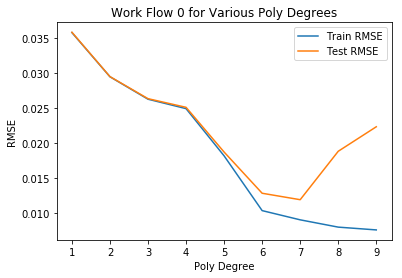

Work Flow 1
Train RMSE:  [0.14876603056260168, 0.12984413828137184, 0.11533001582391803, 0.089831545293320714, 0.065707659350818626, 0.042532372345961175, 0.020756415526454696, 0.0080810322236137717, 0.0054364203943832847]
Test RMSE:  [0.14891860201393806, 0.13009650190777197, 0.11685267028724416, 0.090557237690219602, 0.066301237417921016, 0.043466496234742052, 0.022619779364947669, 0.016050811167531709, 0.014643568483903132]


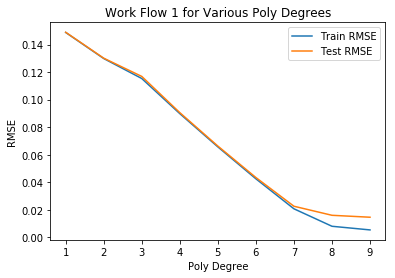

Work Flow 2
Train RMSE:  [0.042909320639077243, 0.03845993156707897, 0.034912254383492554, 0.031861766053443909, 0.026443992090097505, 0.021989586678778934, 0.020998755166732015, 0.019341305366872286, 0.017818246561338468]
Test RMSE:  [0.043066905847879304, 0.038861332202830473, 0.035624647348688109, 0.03312007056015788, 0.027656335599012351, 0.026943432187021794, 0.030975044071733959, 0.041101166131729691, 0.061025546832239159]


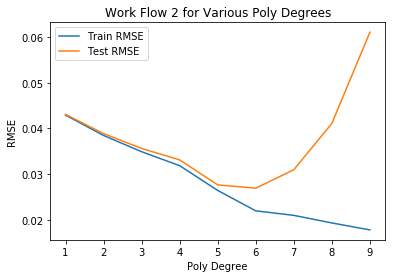

Work Flow 3
Train RMSE:  [0.0072438788738825345, 0.0063798475163659432, 0.0060245160864939281, 0.0055220430886261064, 0.0049049498397625161, 0.0046014427484824712, 0.0045420345518851404, 0.0042813021741649592, 0.0045562057771475883]
Test RMSE:  [0.007260894242099694, 0.0064263656987339551, 0.0060859324174098294, 0.005693827031599567, 0.0050616657599734599, 0.0054393928071319372, 0.0093861747658765416, 0.012811881841530421, 0.035398013095147375]


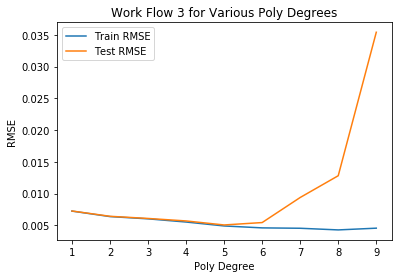

Work Flow 4
Train RMSE:  [0.085921936793271939, 0.069192398447646422, 0.068123526307968404, 0.056254736755275259, 0.044011832283068625, 0.04218488638665472, 0.026385301881806572, 0.024167134839290935, 0.021889831408209905]
Test RMSE:  [0.085990614115654451, 0.069340664871216928, 0.071957999214204246, 0.05759587097304518, 0.049870096568613201, 0.10632152524330896, 0.086491071783058801, 0.074409973012360034, 0.10172874026330511]


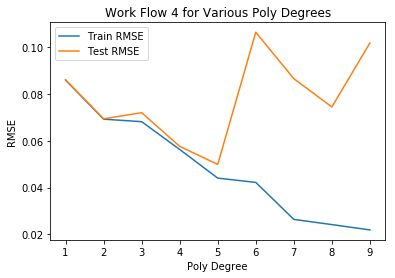

In [4]:
range_of_degree = range(1, 10)
kf = KFold(n_splits = 10)
train_data = copy.deepcopy(Data)
train_data.drop(labels[6],1,inplace = True)
df = pd.DataFrame(train_data)
grouped = df.groupby(['Work-Flow-ID'])
test_rmse_list = []
train_rmse_list = []
for work_flow_data in grouped:
    work_flow_number = list(work_flow_data)[0]
    work_flow = list(work_flow_data)[1]   
    work_flow_train = np.asarray(work_flow)
    
    work_flow_array = work_flow_train[:, :5]
    target_data = work_flow_train[:, 5]
          
    train_mse = [0] * len(range_of_degree)
    test_mse = [0] * len(range_of_degree)
    for train_index, test_index in kf.split(work_flow_array):
        train_sample = work_flow_array[train_index, :]
        train_target = target_data[train_index]

        test_sample = work_flow_array[test_index, :]
        test_target = target_data[test_index]
            
        for i, degree in enumerate(range_of_degree):
            polynomial_features = PolynomialFeatures(degree)
            linear_regression = LinearRegression()
        
            pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
            pipeline.fit(train_sample, train_target)

            train_predicted = pipeline.predict(train_sample)
            test_predicted = pipeline.predict(test_sample)
        
            train_mse[i] += mean_squared_error(train_target, train_predicted)
            test_mse[i] += mean_squared_error(test_target, test_predicted)
    
    train_rmse = map(lambda x: (x / 10) ** 0.5, train_mse)
    test_rmse = map(lambda x: (x / 10) ** 0.5, test_mse)

    print 'Work Flow ' + str(work_flow_number)
    print 'Train RMSE: ', train_rmse
    print 'Test RMSE: ', test_rmse
    plt.plot(range_of_degree, train_rmse, label = 'Train RMSE')
    plt.plot(range_of_degree, test_rmse, label = 'Test RMSE')
    title = str(work_flow_number)
    plt.title('Work Flow ' + title + ' for Various Poly Degrees')
    plt.xlabel('Poly Degree')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_result(target, predict, title = ""):
    x = range(len(predict))
    
    area = np.pi * (1)**2  # 0 to 15 point radii
    plt.scatter(x, predict, color = 'red', s=area, label='prediction')
    plt.scatter(x, target, color = 'blue', s=area, label='True Value')
    plt.title("fitted values against true values")
    plt.legend()
    plt.show()
    
    plt.scatter(x, predict, color = 'red',s=area, label='prediction')
    plt.scatter(x, target - predict, color = 'blue', s=area, label='Residuals')
    plt.title("residuals versus fitted values")
    plt.legend()
    plt.show()


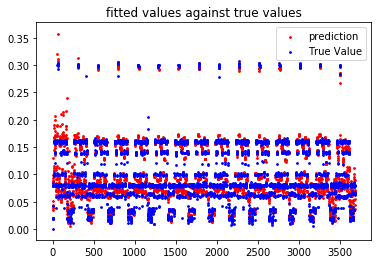

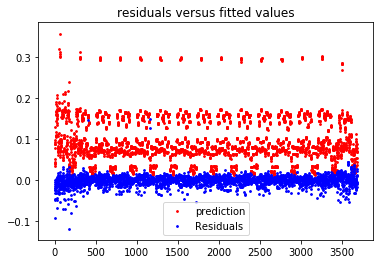

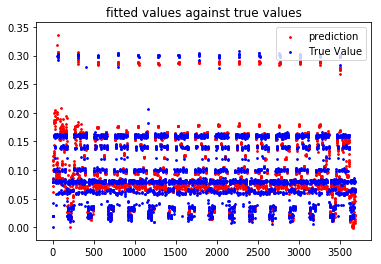

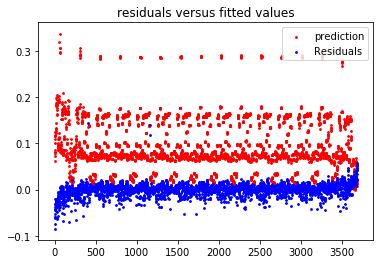

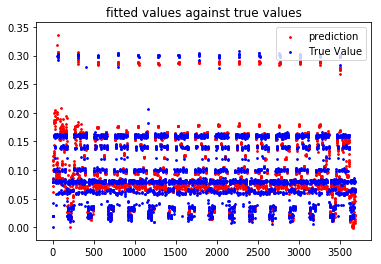

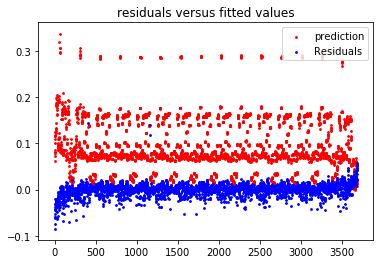

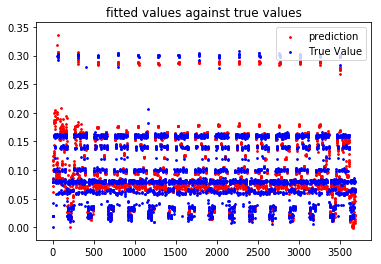

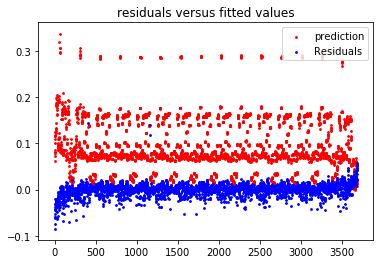

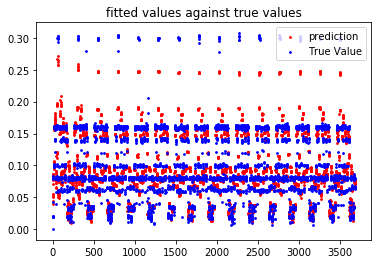

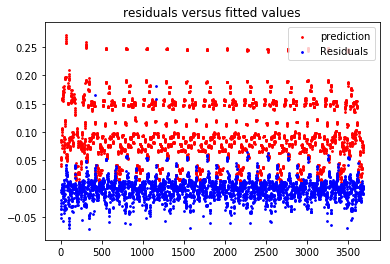

In [42]:
train_data = copy.deepcopy(Data)
train_data.drop(labels[6],1,inplace = True)
df = pd.DataFrame(train_data)
grouped = df.groupby(['Work-Flow-ID'])
poly_degree = [7, 6, 6, 6, 5]
i = 0
for work_flow in grouped:
    work_flow_data = list(work_flow)[1]
    train = work_flow_data.iloc[:, :5]
    target = work_flow_data.iloc[:, 5]
    
    polynomial_features = PolynomialFeatures(poly_degree[i])
    i += 1
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    predicted = cross_val_predict(pipeline, train_0, target_0, cv = 10)
    plot_result(target_0, predicted)